<a href="https://colab.research.google.com/github/goldFeCastle/neckUSimage/blob/master/ver3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import os
import numpy as np
import keras
import matplotlib.pyplot as plt

from skimage.transform import resize
from keras.models import Model
from keras import layers, models
from keras import backend as K

Using TensorFlow backend.


In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
K.set_image_data_format('channels_last')  # TF dimension ordering in this code

create_image_rows = 420
create_image_cols = 580

smooth = 1.0

In [0]:
image_t = np.load('/content/gdrive/My Drive/Colab Notebooks/ultrasound_neck_nerve_seg/image_T.npy')
mask_t = np.load('/content/gdrive/My Drive/Colab Notebooks/ultrasound_neck_nerve_seg/mask_T.npy')

In [0]:
train_image_rows = 96
train_image_cols = 96

def preprocess(imgs):
    imgs_p = np.ndarray(
        (imgs.shape[0], train_image_rows, train_image_cols), dtype=np.uint8)
    for i in range(imgs.shape[0]):
        imgs_p[i] = resize(
            imgs[i], (train_image_rows, train_image_cols), preserve_range=True)

    imgs_p = imgs_p[..., np.newaxis]
    return imgs_p

In [0]:
image_c = preprocess(image_t)
mask_c = preprocess(mask_t)

image_c = image_c.astype('float32')
mean = np.mean(image_c)  # mean for data centering
std = np.std(image_c)  # std for data normalization

image_c -= mean
image_c /= std

mask_c = mask_c .astype('float32')
mask_c /= 255.  # scale masks to [0, 1]

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


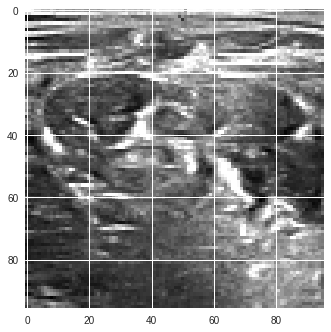

In [0]:
image_test_uu = image_c.reshape(2323, 96, 96)

from skimage import feature

plt.imshow(image_test_uu[0],cmap='gray')

In [0]:
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

In [0]:
def get_unet():
    inputs = layers.Input((96, 96, 1))
    
    conv0_1 = layers.DepthwiseConv2D(32, 2, padding='same')(inputs)
    conv0_1 = layers.BatchNormalization()(conv0_1)
    conv0_1 = layers.Activation('relu')(conv0_1)
    conv0_2 = layers.Conv2D(32, 2, padding='same')(inputs)
    conv0_2 = layers.BatchNormalization()(conv0_2)
    conv0_2 = layers.Activation('relu')(conv0_2)
    pool0_1 = layers.MaxPool2D(pool_size=(2, 2))(conv0_2)
    pool0_1 = layers.Conv2D(1, 1, padding='same')(pool0_1)
    pool0_2 = layers.merge.add([conv0_1,pool0_1])

    conv1_1 = layers.DepthwiseConv2D(128, 2, padding='same')(pool0_2)
    conv1_1 = layers.BatchNormalization()(conv1_1)
    conv1_1 = layers.Activation('relu')(conv1_1)
    conv1_2 = layers.Conv2D(64, 2, padding='same')(pool0_2)
    conv1_2 = layers.BatchNormalization()(conv1_2)
    conv1_2 = layers.Activation('relu')(conv1_2)
    pool1_1 = layers.MaxPool2D(pool_size=(2, 2))(conv1_2)
    pool1_1 = layers.Conv2D(1, 1, padding='same')(pool1_1)
    pool1_2 = layers.merge.add([conv1_1,pool1_1])
    
    conv2_1 = layers.DepthwiseConv2D(128, 2, padding='same')(pool1_2)
    conv2_1 = layers.BatchNormalization()(conv2_1)
    conv2_1 = layers.Activation('relu')(conv2_1)
    conv2_2 = layers.Conv2D(128, 2, padding='same')(pool1_2)
    conv2_2 = layers.BatchNormalization()(conv2_2)
    conv2_2 = layers.Activation('relu')(conv2_2)
    pool2_1 = layers.MaxPool2D(pool_size=(2, 2))(conv2_2)
    pool2_1 = layers.Conv2D(1, 1, padding='same')(pool2_1)
    pool2_2 = layers.merge.add([conv2_1,pool2_1])
    
    conv3_1 = layers.DepthwiseConv2D(256, 2, padding='same')(pool2_2)
    conv3_1 = layers.BatchNormalization()(conv3_1)
    conv3_1 = layers.Activation('relu')(conv3_1)
    conv3_2 = layers.Conv2D(256, 2, padding='same')(pool2_2)
    conv3_2 = layers.BatchNormalization()(conv3_2)
    conv3_2 = layers.Activation('relu')(conv3_2)
    pool3_1 = layers.MaxPool2D(pool_size=(2, 2))(conv3_2)
    pool3_1 = layers.Conv2D(1, 1, padding='same')(pool3_1)
    pool3_2 = layers.merge.add([conv3_1,pool3_1])

    conv4 = layers.Conv2D(512, 3, activation='relu', padding='same')(pool3_2)
    conv4 = layers.Conv2D(512, 3, activation='relu', padding='same')(conv4)

    up5 = layers.Conv2DTranspose(128, 3, strides=(2, 2),activation='relu', padding='same')(conv4)
    merge5 = layers.concatenate([conv3_2, up5])
    conv5 = layers.Conv2D(128, 3, activation='relu', padding='same')(merge5)
    conv5 = layers.Conv2D(128, 3, activation='relu', padding='same')(conv5)

    up6 = layers.Conv2DTranspose(64, 3, strides=(2, 2),activation='relu', padding='same')(conv5)
    merge6 = layers.concatenate([conv2_2, up6])
    conv6 = layers.Conv2D(64, 3, activation='relu', padding='same')(merge6)
    conv6 = layers.Conv2D(64, 3, activation='relu', padding='same')(conv6)

    up7 = layers.Conv2DTranspose(32, 3, strides=(2, 2),activation='relu', padding='same')(conv6)
    merge7 = layers.concatenate([conv1_2, up7])
    conv7 = layers.Conv2D(32, 3, activation='relu', padding='same')(merge7)
    conv7 = layers.Conv2D(32, 3, activation='relu', padding='same')(conv7)

    up8 = layers.Conv2DTranspose(16, 3, strides=(2, 2),activation='relu', padding='same')(conv7)
    merge8 = layers.concatenate([conv0_2, up8])
    conv8 = layers.Conv2D(16, 3, activation='relu', padding='same')(merge8)
    conv8 = layers.Conv2D(16, 3, activation='relu', padding='same')(conv8)
    
    conv8 = layers.Conv2D(1, 1, activation='sigmoid', padding='same')(conv8)

    model = Model(inputs=[inputs], outputs=[conv8])

    model.compile(optimizer=keras.optimizers.Adam(lr=0.00001),
                  loss=dice_coef_loss, metrics=[dice_coef])

    print((model.summary()))

    return model

In [0]:
unet = get_unet()
#net = unet()
filepath = 'weghit1'
model_checkpoint = keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', save_best_only=True)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 96, 96, 1)    0                                            
__________________________________________________________________________________________________
conv2d_39 (Conv2D)              (None, 96, 96, 32)   160         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_18 (BatchNo (None, 96, 96, 32)   128         conv2d_39[0][0]                  
__________________________________________________________________________________________________
activation_18 (Activation)      (None, 96, 96, 32)   0           batch_normalization_18[0][0]     
__________________________________________________________________________________________________
depthwise_

In [0]:
image_train = image_c[0:1858]
image_valid = image_c[1858:]

mask_train = mask_c[0:1858]
mask_valid = mask_c[1858:]

In [0]:
train_datagen = keras.preprocessing.image.ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    zca_whitening=True ,
    zca_epsilon=1e-06,
    width_shift_range=0.2,
    height_shift_range=0.2,
    fill_mode = 'nearest',
    horizontal_flip=True)
test_datagen = keras.preprocessing.image.ImageDataGenerator()

train_data = train_datagen.flow(image_train, mask_train,batch_size=64)
valid_data = test_datagen.flow(image_valid, mask_valid,batch_size=64)

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image.py:841: UserWarning: This ImageDataGenerator specifies `zca_whitening` which overrides setting of`featurewise_std_normalization`.
  warnings.warn('This ImageDataGenerator specifies '


In [0]:
print(('-'*30))
print('Fitting model...')
print(('-'*30))
from keras.callbacks import EarlyStopping, TensorBoard
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=20, verbose=1, mode='auto')
tb_hist = TensorBoard(log_dir='./logs',
                      histogram_freq=0, write_grads=True, write_images=True)

history = unet.fit_generator(train_data,steps_per_epoch=100, epochs=200, verbose=1, shuffle=True,
                   validation_data=valid_data, validation_steps=10 ,callbacks=[tb_hist,early_stopping])

print(('-'*30))
print('Done !!')
print(('-'*30))

------------------------------
Fitting model...
------------------------------
Epoch 1/200


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image.py:1131: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image.py:1150: UserWarning: This ImageDataGenerator specifies `zca_whitening`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


100/100 [==============================] - 40s 396ms/step - loss: -0.0550 - dice_coef: 0.0550 - val_loss: -0.0561 - val_dice_coef: 0.0561
Epoch 2/200
100/100 [==============================] - 37s 370ms/step - loss: -0.0574 - dice_coef: 0.0574 - val_loss: -0.0678 - val_dice_coef: 0.0678
Epoch 3/200
100/100 [==============================] - 37s 365ms/step - loss: -0.0813 - dice_coef: 0.0813 - val_loss: -0.0987 - val_dice_coef: 0.0987
Epoch 4/200
100/100 [==============================] - 37s 368ms/step - loss: -0.1190 - dice_coef: 0.1190 - val_loss: -0.1664 - val_dice_coef: 0.1664
Epoch 5/200
100/100 [==============================] - 37s 369ms/step - loss: -0.3404 - dice_coef: 0.3404 - val_loss: -0.2828 - val_dice_coef: 0.2828
Epoch 6/200
100/100 [==============================] - 37s 367ms/step - loss: -0.4175 - dice_coef: 0.4175 - val_loss: -0.4001 - val_dice_coef: 0.4001
Epoch 7/200
100/100 [==============================] - 37s 370ms/step - loss: -0.4301 - dice_coef: 0.4301 - val_

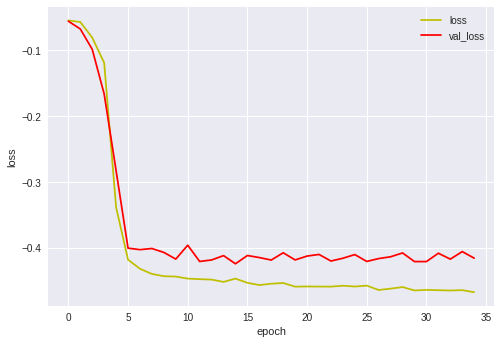

In [0]:
plt.plot(history.history['loss'], 'y', label='loss')
plt.plot(history.history['val_loss'], 'r', label='val_loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(loc='upper right')
plt.show()

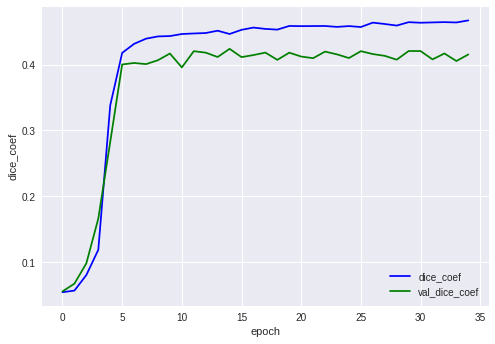

In [0]:
plt.plot(history.history['dice_coef'], 'b', label='dice_coef')
plt.plot(history.history['val_dice_coef'], 'g', label='val_dice_coef')
plt.xlabel('epoch')
plt.ylabel('dice_coef')
plt.legend(loc='lower right')
plt.show()

In [0]:
import pandas as pd

df = pd.DataFrame({"loss": history.history['loss'],  "val_loss": history.history['val_loss'],
                   "dice_coef": history.history['dice_coef'],  "val_dice_coef": history.history['val_dice_coef'], })
df.to_csv('history_{:2.2}.csv'.format(history.history['val_dice_coef'][-1]))

In [0]:
#imgs_mask_test = unet.predict(data.imgs_test, verbose=1)
mask_predict = unet.evaluate_generator(valid_data, steps=5)
print("%s: %.2f%%" %(unet.metrics_names[1], mask_predict[1]*100))

dice_coef: 42.38%


In [0]:
# 6. 모델 사용하기
print("-- Predict --")
output = unet.predict_generator(valid_data, steps=5)
np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})

-- Predict --


In [0]:
import cv2

np.shape(mask_predict)

mask_predict = unet.predict(image_valid, verbose=1)
score = unet.evaluate(mask_predict, mask_valid , verbose=1)

465/465 [==============================] - 1s 3ms/step


In [0]:
print('Test score:', score[0])
print('Test accuracy:', score[1])

Test score: -0.043625002106030784
Test accuracy: 0.04362500183364396


In [0]:
mask_r = mask_predict.reshape(465, 96, 96)
mask_test_u = mask_valid.reshape(465, 96, 96)
image_test_u = image_valid.reshape(465, 96, 96)

In [0]:
img_test_o = (mask_r*2)+image_test_u
img_predict_o =image_test_u+(mask_test_u*2)

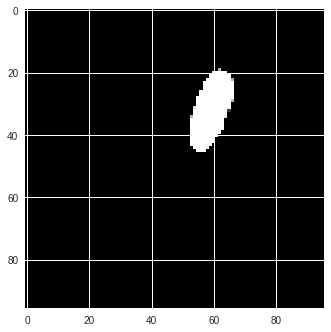

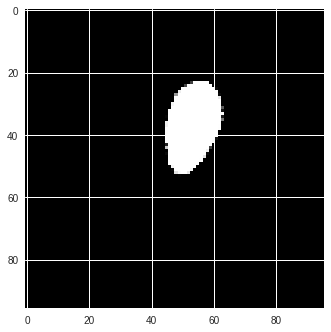

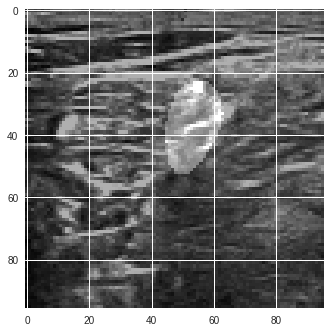

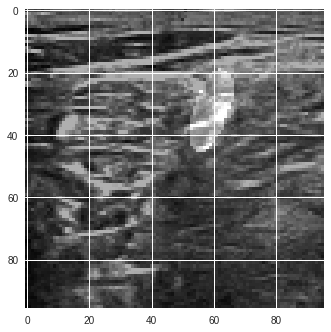

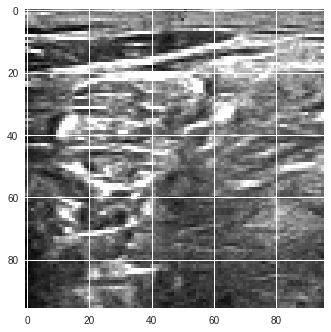

In [0]:
plt.figure()
plt.imshow(mask_test_u[35], cmap='gray')
plt.show()

plt.figure()
plt.imshow( mask_r[35], cmap='gray')
plt.show()

plt.figure()
plt.imshow(img_test_o[35], cmap='gray')
plt.show()

plt.figure()
plt.imshow(img_predict_o[35], cmap='gray')
plt.show()